In [1]:
import numpy as np

In [2]:
def shift(register, feedback, output):
    """GPS Shift Register
    
    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:
    
    """
    
    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]
        
    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2
    
    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]
        
    # put feedback in position 1
    register[0] = fb
    
    return out

In [3]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

In [4]:
def PRN(sv):
    """Build the CA code (PRN) for a given satellite ID
    
    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite
    
    """
    
    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here
    
    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table
        
        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca


In [5]:
res = PRN(2)
print(res[:10])
#I stole literally all of this from https://natronics.github.io/blag/2014/gps-prn/

[1, 1, 1, 0, 0, 1, 0, 0, 0, 0]


In [6]:
fs = 1.023*16*1e6
data = np.fromfile('adc_sample_data.bin', dtype=np.int8)
print(len(data))
data = np.sign(data[:len(data)//10])
t = np.arange(0,len(data))*1/(fs)

16368000


In [7]:
f_carrier = 4.128460*1e6
I = np.sign(data*np.cos(2*np.pi*f_carrier*t))
Q = np.sign(data*np.sin(2*np.pi*f_carrier*t))

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t[:100], I[:100])
plt.plot(t[:100], Q[:100])
plt.show()

<Figure size 640x480 with 1 Axes>

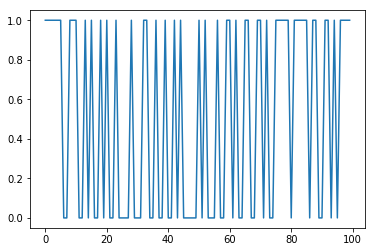

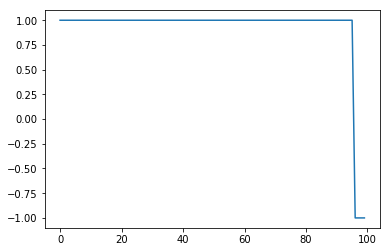

In [9]:
code = PRN(22)
plt.figure()
plt.plot(code[:100])
code_at_freq = np.repeat(code, 16)*2 - 1
plt.figure()
plt.plot(code_at_freq[:100])

In [10]:
correlator_out = np.correlate(I, code_at_freq)
print(len(correlator_out))

1620433


In [11]:
correlator_out_trunc = correlator_out[::4]
print(max(correlator_out_trunc))

2812.0


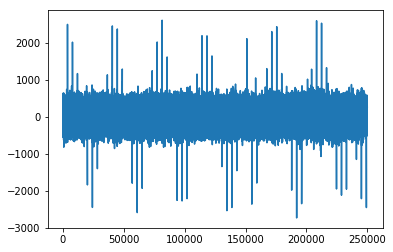

In [12]:
plt.plot(correlator_out[:1000000:4])

In [13]:
print(np.argmax(correlator_out[:40000]))

15040


In [38]:
from blocks import *
raw_data = np.fromfile('adc_sample_data.bin', dtype=np.int8)[15041:]
print(len(raw_data))
# Data sample rate
fs = 1.023*16*1e6

# The data contains the following SV's with at the following frequencies:
# The frequencies are in MHz
sv_list = [22, 3, 19, 14, 18, 11, 32, 6]
sv_freqs = [4.128460, 4.127190, 4.129280,
            4.133130, 4.127310, 4.133280,
            4.134060,4.127220]

sv = sv_list[0]
sv_freq = sv_freqs[0]

# We'll start off with the NCO Width set to 10
nco_width = 16
ideal_carrier_nco_code = sv_freq*1e6 * (2**nco_width) / fs
print(ideal_carrier_nco_code)
carrier_nco_code = round(ideal_carrier_nco_code)
print(carrier_nco_code)

num_cycles = len(raw_data)//10
print(num_cycles)

adc = ADC(np.sign(raw_data))
nco_carrier = NCO(nco_width, False)

multI = MUL()
multQ = MUL()

multIe = MUL()
multIp = MUL()
multIl = MUL()
multQe = MUL()
multQp = MUL()
multQl = MUL()

ca = CA()

intdumpI = IntDump()
intdumpQ = IntDump()

# ki = 1, kp = 1, second discriminator
dll = DLL(0.5, 1, 1)
# Disabling the Costas loop for now and forcing the right frequency
costas = Costas(1,[1,1,1],1,1,1)    

nco_code = NCO(nco_width, True)
packet = Packet()

# FIXME: Initial DLL and Costas loop values
dll_out = 1023e3*(2**nco_width)/fs
print(dll_out)
costas_out = carrier_nco_code
I_samples = []
Q_samples = []
I_integ_samples = []
Q_integ_samples = []
I_dump_samples = []
Q_dump_samples = []
dll_out_arr = []
processed = False
reset = False
dump_count = 0 

for x in range(0, num_cycles):
    adc_data = np.sign(adc.update())
    cos_out, sin_out  = nco_carrier.update(costas_out)        
    I = multI.update(adc_data, cos_out)
    Q = multQ.update(adc_data, sin_out)
    I_samples.append(I)
    Q_samples.append(Q)
    
    f_out, f2_out = nco_code.update(1023e3*(2**nco_width)/fs)
    e, p, l, dump = ca.update(f_out, f2_out, sv)

    I_e = multIe.update(I, e)        
    I_p = multIp.update(I, p)
    I_l = multIl.update(I, l)
    Q_e = multQe.update(Q, e)
    Q_p = multQp.update(Q, p)
    Q_l = multQl.update(Q, l)
    I_sample = [I_e, I_p, I_l]
    Q_sample = [Q_e, Q_p, Q_l]
    
    if dump:
        dump_count += 1
    
    if dump_count == 5 and not processed:
        print(x)
        dll_out, dis_out = dll.update(I_int, Q_int, 1023e3*(2**nco_width)/fs, 0)
        I_dump_samples.append(I_int.copy())
        Q_dump_samples.append(Q_int.copy())
        dll_out_arr.append(dll_out)
        processed = True
        dump_count = 0
    elif not reset: 
        processed = False
        
    I_integ_samples.append(I_sample)
    Q_integ_samples.append(Q_sample)
    I_int, reset = intdumpI.update(np.array(I_sample), dump)
    Q_int, reset = intdumpQ.update(np.array(Q_sample), dump)


16352959
16529.98256109482
16530
1635295
4096.000000000001
81834
DIS OUT:  0.3268016368853376
163673
DIS OUT:  0.38142590515294456
245512
DIS OUT:  0.40535749384562797
327351
DIS OUT:  0.4805533258101837
409189
DIS OUT:  0.4121301984090804
491028
DIS OUT:  0.42110241964448536
572867
DIS OUT:  0.476609443609731
654706
DIS OUT:  0.4029515328856039
736544
DIS OUT:  0.4517361914137562
818383
DIS OUT:  0.46363011789119335
900222
DIS OUT:  0.45956129674389407
982061
DIS OUT:  0.39180583607707303
1063899
DIS OUT:  0.4090676565212025
1145738
DIS OUT:  0.43814764140601514
1227577
DIS OUT:  0.42884507406149663
1309416
DIS OUT:  0.4713687205994027
1391254
DIS OUT:  0.45318607498320157
1473093
DIS OUT:  0.4468169458707441
1554932
DIS OUT:  0.4811971104955581


In [39]:
I_out = np.array(I_samples)
Q_out = np.array(Q_samples)
I_dump_samples = np.array(I_dump_samples)
Q_dump_samples = np.array(Q_dump_samples)
I_integ_samples = np.array(I_integ_samples)
Q_integ_samples = np.array(Q_integ_samples)

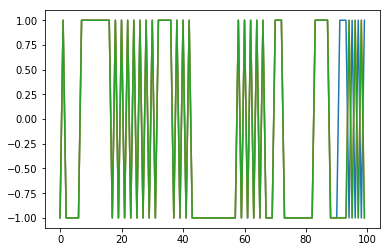

In [40]:
plt.plot(I_integ_samples[:100])

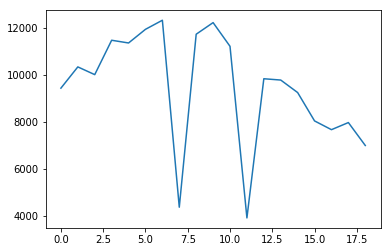

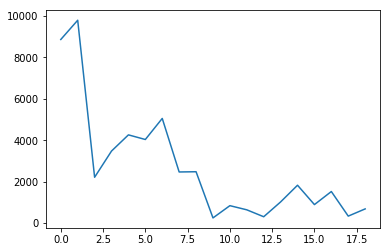

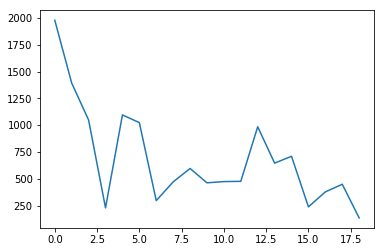

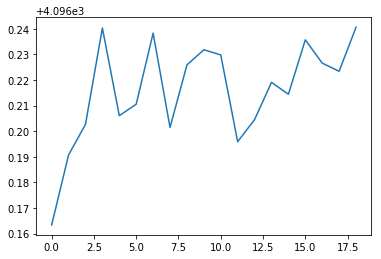

In [41]:
early_mag = np.sqrt(I_dump_samples[:,0]**2 + Q_dump_samples[:,0]**2)
plt.plot(early_mag)
plt.figure()
prompt_mag = np.sqrt(I_dump_samples[:,1]**2 + Q_dump_samples[:,1]**2)
plt.plot(prompt_mag)
plt.figure()
late_mag = np.sqrt(I_dump_samples[:,2]**2 + Q_dump_samples[:,2]**2)
plt.plot(late_mag)
plt.figure()
plt.plot(dll_out_arr)

In [42]:
for i in range(len(dll_out_arr)):
    print(early_mag[i], prompt_mag[i], late_mag[i], dll_out_arr[i])

9445.032556852306 8864.772980736732 1978.5449198843073 4096.163400818444
10349.46539682123 9794.554099089963 1392.265060970791 4096.190712952577
10020.254387988361 2207.9352345573907 1047.4779233950471 4096.202678746924
11484.200015673709 3473.851177008019 227.75864418282788 4096.240276662906
11368.206894669009 4255.943608648968 1095.1529573534465 4096.206065099205
11949.206919289665 4032.251232252276 1023.5164874099488 4096.210551209823
12336.231596399282 5050.322959969986 295.4623495472816 4096.238304721805
4375.612642819288 2463.047299586429 470.28714632658205 4096.201475766444
11740.946639858304 2474.6272446572634 595.3990258641678 4096.2258680957075
12235.25406356566 243.1830586204557 461.7899955607527 4096.231815058946
11226.148137273087 835.3358605974007 473.102525886303 4096.229780648373
3919.079738918309 634.2633522441605 475.46398391465993 4096.19590291804
9845.234786433486 300.0 984.8004874084903 4096.204533828261
9789.746166270093 1015.7292946449857 645.440934555595 4096.21

In [25]:
code = PRN(22)
code_at_freq = np.repeat(code, 16)*2 - 1
correlated_out = np.correlate(code_at_freq, I_out, mode='full')
correlated_out_Q = np.correlate(code_at_freq, Q_out, mode='full')

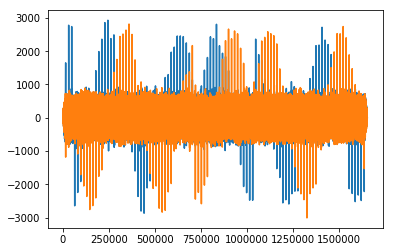

In [26]:
plt.plot(correlated_out)
plt.plot(correlated_out_Q)

In [21]:
abs_corr = np.abs(correlated_out)
indices = np.where(abs_corr > 1000)
print(indices)
print(len(indices[0]))

(array([  14892,   14893,   14894, ..., 1635300, 1635301, 1635302]),)
1223


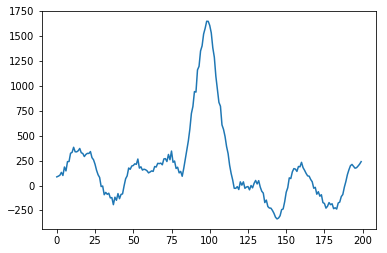

In [22]:
plt.plot(correlated_out[14800:15000])

In [23]:
new_indices = []
prev_index = 0
for index in indices[0]:
    print(index)
    if index - prev_index > 800:
        new_indices.append(index)
    prev_index = index

14892
14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
31257
31258
31259
31260
31261
31262
31263
31264
31265
31266
31267
31268
31269
31270
31271
31272
31273
31274
31275
31276
47627
47628
47629
47630
47631
47632
47633
47634
47635
47636
47637
47638
47639
47640
47641
47642
47643
47644
47645
47646
47647
63992
63993
63994
63995
63996
63997
63998
63999
64000
64001
64002
64003
64004
64005
64006
64007
64008
64009
64010
64011
80362
80363
80364
80365
80366
80367
80368
80369
80370
80371
80372
80373
80374
80375
80376
80377
80378
80379
96732
96733
96734
96735
96736
96737
96738
96739
96740
96741
96742
96743
96744
96745
96746
113099
113100
113101
113102
113103
113104
113105
113106
113107
113108
113109
113110
178571
178572
178573
178574
178575
178576
178577
178578
178579
178580
178581
178582
178583
194936
194937
194938
194939
194940
194941
194942
194943
194944
194945
194946
194947
194948
194949
194950
194951
211303
211304
211305
211306
211307
211308
211309
211310
211311
211312
2

In [24]:
print(new_indices)

[14892, 31257, 47627, 63992, 80362, 96732, 113099, 178571, 194936, 211303, 227669, 244037, 260405, 276774, 293143, 309516, 374986, 391350, 407715, 424079, 440448, 456816, 473186, 489555, 505926, 555024, 571395, 587759, 604124, 620493, 636860, 653229, 669596, 685966, 702338, 767803, 784169, 800535, 816904, 833272, 849639, 866009, 882376, 898747, 964216, 980579, 996949, 1013316, 1029684, 1046052, 1062422, 1078788, 1086975, 1095158, 1160625, 1176994, 1193360, 1209727, 1226095, 1239968, 1242463, 1258832, 1275199, 1340672, 1357038, 1373405, 1389771, 1406137, 1422508, 1438876, 1455244, 1471611, 1553446, 1569814, 1586182, 1602551, 1618918, 1635285]


In [18]:
new_indices = np.array(new_indices)
np.diff(new_indices) / 1023

array([88.59139785, 92.58162268])